In [12]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

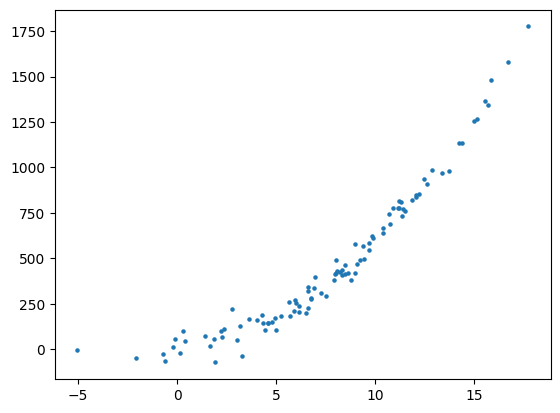

In [13]:
# 模拟数据
X = np.random.randn(100) * 5 + 7
error = np.random.randn(100) * 50
Y_obs = 5 * X ** 2 + 10 * X + error

plt.scatter(X, Y_obs, s=5)

In [15]:
# Total Variation regularization strength
lambda_tv = 0.1

# TV minimization regularization
with pm.Model() as model_tv:
    # 定义随机变量 a, b, c
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10)
    c = pm.Normal('c', mu=0, sigma=10)
    
    # 定义预测值
    Y_pred = a * X ** 2 + b * X + c
    
    # 定义 likelihood
    likelihood = pm.Normal('Y_obs', mu=Y_pred, sigma=50, observed=Y_obs)
    
    # Total variation prior regularization
    delta_a = pm.Laplace('delta_a', mu=0, b=1/lambda_tv, shape=len(X) - 1)
    delta_b = pm.Laplace('delta_b', mu=0, b=1/lambda_tv, shape=len(X) - 1)
    delta_c = pm.Laplace('delta_c', mu=0, b=1/lambda_tv, shape=len(X) - 1)

    # 加入正则项，使用 pm.logp
    for i in range(1, len(X)):
        pm.Potential(f'a_tv_{i}', pm.logp(pm.Laplace.dist(mu=a, b=1/lambda_tv), delta_a[i-1]))
        pm.Potential(f'b_tv_{i}', pm.logp(pm.Laplace.dist(mu=b, b=1/lambda_tv), delta_b[i-1]))
        pm.Potential(f'c_tv_{i}', pm.logp(pm.Laplace.dist(mu=c, b=1/lambda_tv), delta_c[i-1]))

    # 采样
    trace_tv = pm.sample(1000, tune=1000, return_inferencedata=False)

# 绘制追踪图
pm.plot_trace(trace_tv)
plt.show()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, c, delta_a, delta_b, delta_c]


Output()

In [ ]:
X_test = np.linspace(np.floor(X.min()), np.ceil(X.max()), 100)

# 真值
Y_true = 5 * X_test ** 2 + 10 * X_test

# 计算后验平均值
a_posterior_mean = trace_elastic_net.posterior["a"].mean().values
b_posterior_mean = trace_elastic_net.posterior["b"].mean().values
c_posterior_mean = trace_elastic_net.posterior["c"].mean().values
Y_fit = a_posterior_mean * X_test ** 2 + b_posterior_mean * X_test + c_posterior_mean

# 计算后验标准差
a_posterior_std = trace_elastic_net.posterior["a"].std().values
b_posterior_std = trace_elastic_net.posterior["b"].std().values
c_posterior_std = trace_elastic_net.posterior["c"].std().values
Y_errorpred = a_posterior_std * X_test ** 2 + b_posterior_std * X_test + c_posterior_std

edge1 = Y_fit + Y_errorpred
edge2 = Y_fit - Y_errorpred

crosspoint = 0
for i in range(len(X_test)):
    if edge1[i] < edge2[i]:
        crosspoint = i
        break

MSE = np.mean((Y_fit - Y_true) ** 2)

In [ ]:
# 绘制填充区间
# 绘制数据点
plt.scatter(X, Y_obs, s=5)

# 绘制后验平均拟合线
plt.plot(X_test, Y_fit, color='red', label='a={:.2f} b={:.2f} c={:.2f} MSE={:.2f}'.format(
         a_posterior_mean, b_posterior_mean, c_posterior_mean, MSE))

if crosspoint:
    plt.fill_between(X_test[:crosspoint], edge2[:crosspoint], edge1[:crosspoint], color='blue', alpha=0.3, 
                     label='Uncertainty')
    plt.fill_between(X_test[crosspoint:], edge1[crosspoint:], edge2[crosspoint:], color='blue', alpha=0.3)
else:
    plt.fill_between(X_test, edge2, edge1, color='blue', alpha=0.3)

# 显示图例
plt.legend()

# 显示图表
plt.show()

#lambda=0.1,    alpha=0.05, MSE=347.40, a=4.9...,   b=9....,    c=...
#lambda=0.12,   alpha=0.05, MSE=160.80, a=5.27,     b=6.96,     c=7.08